In [ ]:
import os
os.chdir('../') #if we are in notebooks folder

In [1]:
%pip install -q flax
# %pip install -q regdata
# %pip install -q "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

     |████████████████████████████████| 197 kB 41.3 MB/s 
     |████████████████████████████████| 140 kB 68.5 MB/s 
     |████████████████████████████████| 216 kB 67.2 MB/s 
     |████████████████████████████████| 51 kB 3.2 MB/s 
     |████████████████████████████████| 72 kB 760 kB/s 


In [2]:
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

In [3]:
import flax
import flax.linen as nn
import tensorflow_probability.substrates.jax as tfp


import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn import datasets
from sklearn import preprocessing as sp

# from models import mc_dropout
# from utils import fit

from functools import partial

In [4]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [5]:
dist = tfp.distributions


In [6]:
co2_dataset  = datasets.fetch_openml(data_id=41187, as_frame=True)

In [7]:
co2_dataset.frame.head()

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


In [8]:
co2_df = co2_dataset.frame
co2_df["date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
co2_df = co2_df[["date", "co2"]].set_index("date")

In [9]:
co2_df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [10]:
co2_df = co2_df.resample("M").mean().dropna(axis="index", how="any")

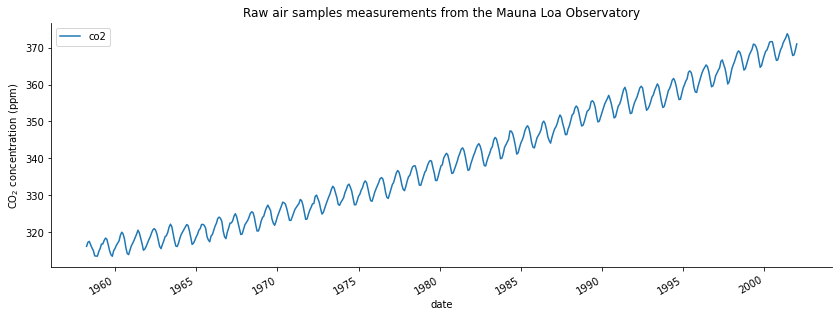

In [11]:
co2_df.plot(figsize=(14,5))
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
sns.despine()

In [12]:
X = (co2_df.index.year + co2_df.index.month / 12).to_numpy().reshape(-1, 1)

In [13]:
s = 200
n = 400
scaler = sp.StandardScaler()
scaler = scaler.fit(X[s:n])
x = scaler.transform(X[s:n])

In [14]:
y = jnp.array(co2_df["co2"][s:n])
min_max = sp.MinMaxScaler()
# y = sp.minmax_scale(co2_df["co2"][s:n],feature_range=(0,5)).reshape(-1,1)
min_max = min_max.fit(y.reshape(-1,1))
y = min_max.transform(y.reshape(-1,1))

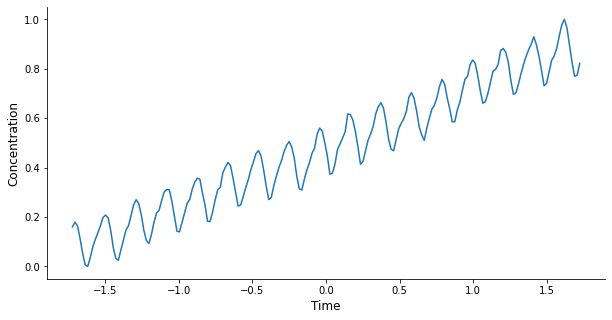

In [15]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
# plt.ylim(-20,20)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
sns.despine()

# Train

In [16]:
class mc_dropout(nn.Module):
    features : list
        
    @nn.compact
    def __call__(self, x, deterministic=True, rate=0.1):
        
        for i, feature in enumerate(self.features):
            x = nn.Dense(feature)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=rate, deterministic=deterministic)(x)

        x = nn.Dense(1)(x)
        return x

    def loss_fn(self, params, x, y, deterministic=False, rate=0.1, rng= jax.random.PRNGKey(0)):
        # key = jax.random.PRNGKey(0)
        y_pred = self.apply(params, x, deterministic, rate, rngs={"dropout":rng})
        loss = jnp.mean((y - y_pred)**2)
        return loss

In [101]:
def fit(model, params, auxs, learning_rate = 0.01, epochs=1000, verbose=False):
    opt = optax.adamw(learning_rate=learning_rate)
    opt_state = opt.init(params)

    partial_loss_fn = partial(model.loss_fn, deterministic=auxs["deterministic"], rate=auxs['rate'])
    loss_grad_fn = jax.jit(jax.value_and_grad(partial_loss_fn))
    losses = []
    upd = jax.jit(opt.update)
    x, y = auxs["X"], auxs["y"]
    rng = jax.random.PRNGKey(0)
    try:
      for i in range(epochs):
        rng, _ = jax.random.split(rng)
        loss_val, grads = loss_grad_fn(params, x, y, rng=rng)
        updates, opt_state = upd(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        losses.append(loss_val)
        if verbose and i % (epochs / 10)== 0:
            print('Loss step {}: '.format(i), loss_val)
    except KeyboardInterrupt:
        print("got it.")
        return params, jnp.array(losses)
    return params, jnp.array(losses)

In [102]:
# load the model
model = mc_dropout(features=[256, 512, 256, 128])

In [103]:
# initialize model
params = model.init(jax.random.PRNGKey(0), x)

In [104]:
# model.tabulate(jax.random.PRNGKey(1), x, deterministic=True)

In [105]:
auxs = {
    "X": x,
    "y": y,
    "deterministic": False,
    "rate": 0.1
}
params, losses =  fit(model, params, auxs, learning_rate=0.0005, epochs=100000, verbose=True)

Loss step 0:  0.2778599
Loss step 10000:  0.0034580713
Loss step 20000:  0.0030637004
Loss step 30000:  0.0027173646
Loss step 40000:  0.002579413
Loss step 50000:  0.0024144554
Loss step 60000:  0.0019194942
Loss step 70000:  0.0018818572
Loss step 80000:  0.0015815593
Loss step 90000:  0.0014013463


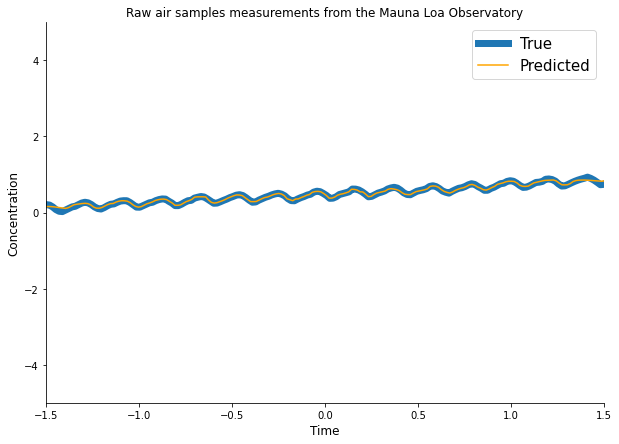

In [106]:
x_grid = jnp.linspace(-1.5,1.5,200).reshape(-1,1)
plt.figure(figsize=(10,7))
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
plt.plot(x,y, linewidth=7, label="True")

plt.plot(x_grid, model.apply(params, x_grid), "orange", label="Predicted")
sns.despine()
plt.legend(fontsize=15)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
plt.xlim(-1.5,1.5)
plt.ylim(-5,5)
plt.savefig("Mauna_loa_CO2_")

# MC_Dropout


In [107]:
def eval(params, x, deterministic=False, rate=0.1, rng=jax.random.PRNGKey(0)):
    return model.apply(params, x, deterministic=False, rate = 0.1, rngs={"dropout": rng})

In [108]:
x_test = jnp.linspace(-1.5, 3, 200).reshape(-1,1)
n_stacks = 100
y_stacks = []
partial_eval_fn = partial(eval, deterministic=False, rate=0.1)
evaluate = jax.jit(partial_eval_fn)
for i in range(n_stacks):
    y_stacks.append(evaluate(params, x_test, rng=jax.random.PRNGKey(i)))

In [109]:
y_stacks = jnp.array(y_stacks)

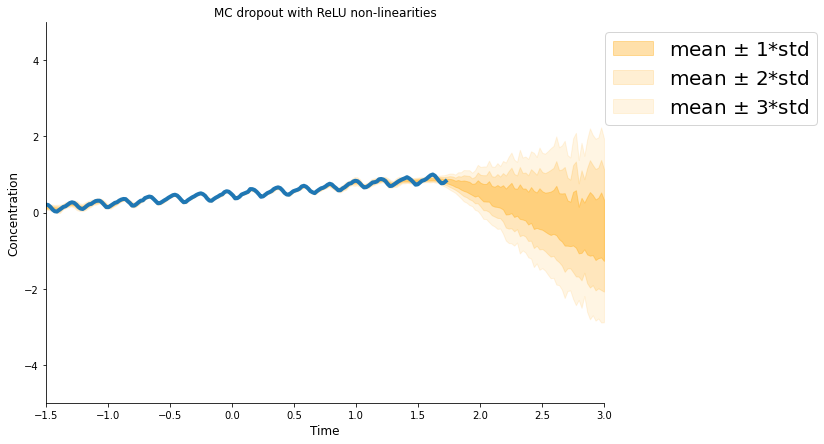

In [110]:
plt.figure(figsize=(10,7))
plt.title("MC dropout with ReLU non-linearities")
plt.plot(x, y, linewidth=4)
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()
for i in range(1, 4):
    plt.fill_between(x_test.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean $\pm$ {i}*std")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
plt.ylim(-5,5)
plt.xlim(-1.5,3)
plt.savefig("Uncertain_Co2_Prediction", bbox_inches="tight")

In [111]:
x_test = jnp.linspace(-1.5, 3, 200).reshape(-1,1)
n_stacks = 100
y_stacks = []
partial_eval_fn = partial(eval, deterministic=False, rate=0.1)
evaluate = jax.jit(partial_eval_fn)
for i in range(n_stacks):
    r_y = evaluate(params, x_test, rng=jax.random.PRNGKey(i))
    r_y = min_max.inverse_transform(r_y)
    y_stacks.append(r_y)

In [112]:
y_stacks = jnp.array(y_stacks)

In [113]:
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()

In [114]:
r_x = scaler.inverse_transform(x)
x_test = scaler.inverse_transform(x_test)
r_y = co2_df["co2"][s:n]

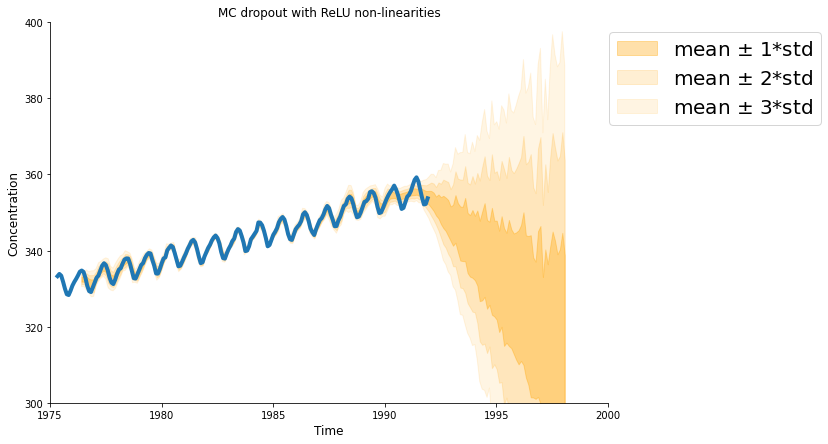

In [115]:
plt.figure(figsize=(10,7))
plt.title("MC dropout with ReLU non-linearities")
plt.plot(r_x, r_y, linewidth=4)

for i in range(1, 4):
    plt.fill_between(x_test.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean $\pm$ {i}*std")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
plt.ylim(300,400)
plt.xlim(1975,2000)
plt.savefig("Uncertain_Co2_Prediction", bbox_inches="tight")